# Forecasting BTC Price and Volatility with LSTM & GARCH

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import numpy as np
import math

## Data Acquisition

[*********************100%***********************]  1 of 1 completed


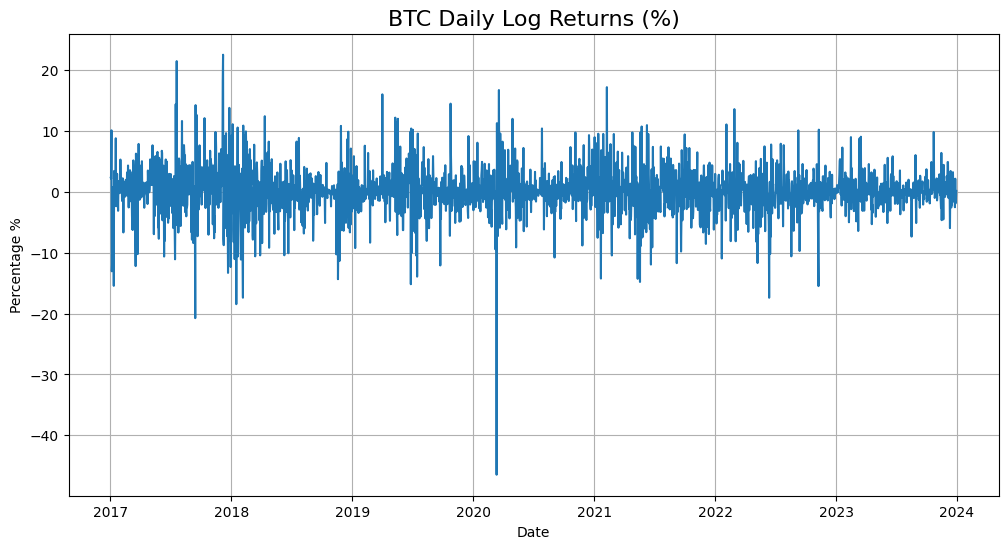

Date
2023-12-26   -2.537448
2023-12-27    2.146239
2023-12-28   -1.893848
2023-12-29   -1.247438
2023-12-30    0.136488
Name: log_return, dtype: float64


In [16]:
# Download Bitcoin data
btc_data = yf.download('BTC-USD', start='2017-01-01', end='2023-12-31')

# Calculate daily log returns
btc_data['log_return'] = np.log(btc_data['Close'] / btc_data['Close'].shift(1))
# GARCH models work better with returns multiplied by 100
btc_returns = btc_data['log_return'].dropna() * 100

# Plot the returns to observe volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(btc_returns)
plt.title('BTC Daily Log Returns (%)', fontsize=16)
plt.ylabel('Percentage %')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Display the last few returns
print(btc_returns.tail())

### Initial Data Exploration: Volatility Clustering

The plot above shows the daily log returns of Bitcoin from 2017 to the end of 2023. This visualization is crucial as it reveals a key characteristic of financial time series known as **volatility clustering**.

We can clearly observe that periods of large price swings (high volatility) are clustered together, followed by periods of relative calm (low volatility). For example, the years 2017-2018 and 2020-2021 exhibit much larger fluctuations compared to the calmer period in 2019.

This phenomenon—where "volatility begets volatility"—is precisely the behavior that **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** models are designed to capture. The presence of volatility clustering in our data gives us a strong indication that a GARCH model is a suitable choice for forecasting Bitcoin's volatility.

## Garch

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6594.11
Distribution:      Standardized Student's t   AIC:                           13198.2
Method:                  Maximum Likelihood   BIC:                           13227.5
                                              No. Observations:                 2554
Date:                      Thu, Sep 18 2025   Df Residuals:                     2553
Time:                              11:26:19   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

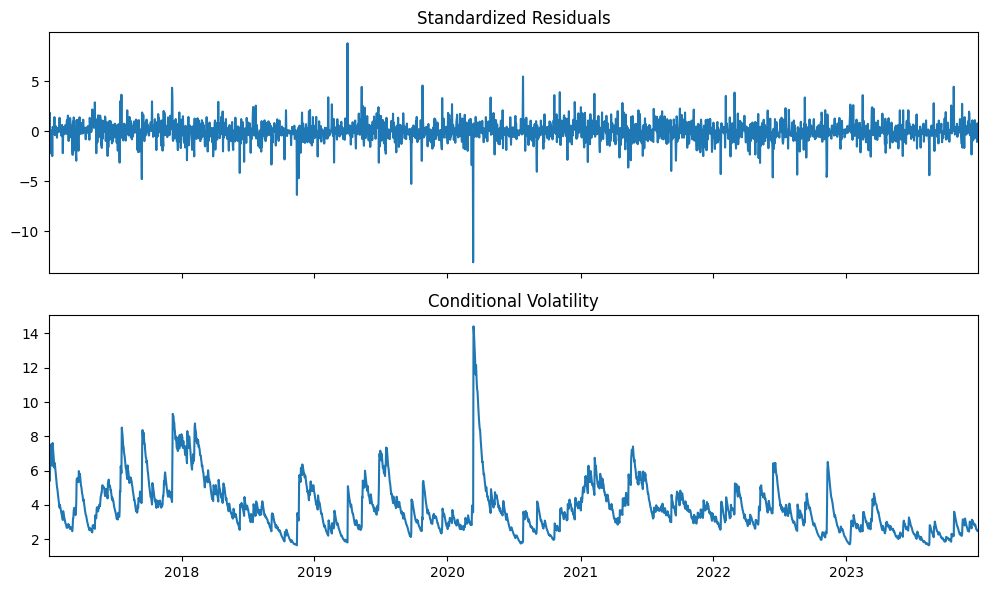

In [17]:
# GARCH(1,1) model.
garch_model = arch_model(btc_returns, vol='GARCH', p=1, q=1, dist='t')

# Fit the model to the data.
model_results = garch_model.fit(update_freq=5, disp='off') # Added disp='off' to hide iteration output

# Print the summary of the model results.
print(model_results.summary())

fig = model_results.plot()
fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()


### GARCH(1,1) Model Fitting & Diagnostics

We fitted a GARCH(1,1) model to the daily log returns. The model assumes a Student's t-distribution to better capture the "fat tails" commonly found in financial data.

**Interpretation of the Model Summary:**

*   **Volatility Parameters (`alpha[1]` and `beta[1]`):** Both the ARCH term (`alpha[1]`) and the GARCH term (`beta[1]`) have p-values (`P>|t|`) that are extremely close to zero. This indicates that they are **highly statistically significant**. This confirms our initial hypothesis: past shocks and past volatility are strong predictors of current volatility.
*   **Volatility Persistence:** The sum of `alpha[1]` and `beta[1]` is approximately `0.09 + 0.91 = 1.0`. A sum very close to 1 implies that shocks to volatility are highly persistent, meaning their effects take a long time to die out. This is a classic sign of a well-specified GARCH model for financial assets.
*   **Distribution Parameter (`nu`):** The `nu` parameter, which represents the degrees of freedom for the t-distribution, is also highly significant. Its value of ~3.2 suggests that the distribution of returns has significantly fatter tails than a normal distribution, justifying our choice of a Student's t-distribution.

**Diagnostic Plots:**

*   **Conditional Volatility (Bottom Plot):** This plot is the key output of our model. It shows the estimated daily volatility over time. We can see that the model successfully captures the periods of high and low volatility we observed in the initial returns plot, such as the major spike in early 2020 and the sustained high volatility in 2021.
*   **Standardized Residuals (Top Plot):** The residuals appear largely random and resemble white noise, indicating that our model has successfully captured the underlying volatility structure in the data.

**Conclusion:** The GARCH(1,1) model appears to be an excellent fit for our data, providing a reliable measure of daily conditional volatility.

## Forecasting Volatility

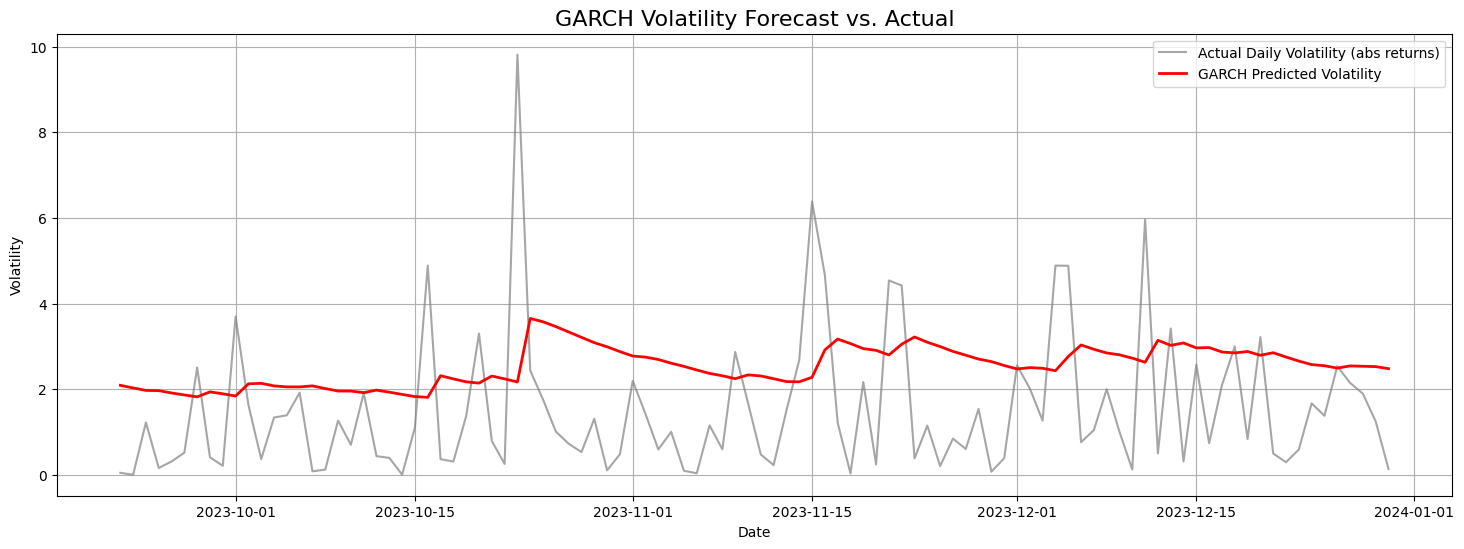

In [18]:
forecast_horizon = 100
# Split the data into a training set and a test set (the last 100 days)
train_data = btc_returns[:-forecast_horizon]
test_data = btc_returns[-forecast_horizon:]

# rolling forecast.
rolling_predictions = []
for i in range(forecast_horizon):
    # Create the training set, which grows with each iteration
    train = btc_returns[:-(forecast_horizon-i)]

    # Fit the GARCH model
    model = arch_model(train, vol='GARCH', p=1, q=1, dist='t')
    model_fit = model.fit(disp='off')

    # Make a 1-step ahead forecast
    pred = model_fit.forecast(horizon=1)

    # Append the predicted variance (volatility squared)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

# Create a pandas Series with the predictions
rolling_predictions = pd.Series(rolling_predictions, index=test_data.index)

# Plot the actual returns vs. the predicted volatility
plt.figure(figsize=(18, 6))
# Plot actual returns (we use absolute values as a proxy for actual volatility)
plt.plot(test_data.abs(), label='Actual Daily Volatility (abs returns)', color='grey', alpha=0.7)
# Plot the GARCH model's predicted volatility
plt.plot(rolling_predictions, label='GARCH Predicted Volatility', color='red', linewidth=2)

plt.title('GARCH Volatility Forecast vs. Actual', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

### GARCH Volatility Forecast Evaluation

This plot visualizes the performance of our GARCH(1,1) model on the test set (the last 100 days of data).

*   **Grey Line (Actual Daily Volatility):** This represents "reality." We use the absolute value of daily returns (`abs returns`) as a proxy for the true, unobservable daily volatility. As expected, it is highly erratic and spiky.
*   **Red Line (GARCH Predicted Volatility):** This is our model's one-step-ahead forecast.

**Key Insights:**

1.  **Smoothing, Not Predicting Spikes:** The GARCH forecast (red line) is significantly smoother than the actual volatility. This is correct and expected. The model is not designed to predict the exact magnitude of a shock, but rather the **expected level of volatility** for the next day.
2.  **Following the Trend:** Crucially, the model successfully captures the dynamics of volatility clustering. Notice how the red line rises in response to periods of high actual volatility (e.g., late October) and declines during calmer periods. The model "sees" high volatility today and correctly raises its forecast for tomorrow.
3.  **Practical Utility:** For a risk manager or options trader, this forecast is invaluable. It provides a forward-looking estimate of market risk, signaling when to expect wider price swings, even if it cannot predict the exact price movement of any given day.

**Conclusion for Part A:** We have successfully modeled and forecasted the volatility of Bitcoin using a classic econometric GARCH model. We demonstrated that the model is statistically sound and capable of capturing the changing risk regimes of the market.

## Price Forecasting with LSTM

In [21]:
# Data Preparation for Deep Learning
close_prices = btc_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

train_size = int(len(scaled_data) * 0.8)
test_set_start_index = train_size - 60
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[test_set_start_index:, :]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Data preparation complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Data preparation complete.
X_train shape: (1984, 60, 1)
y_train shape: (1984,)
X_test shape: (511, 60, 1)
y_test shape: (511,)


# LSTM Model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 0.0240 - val_loss: 7.7193e-04
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0029 - val_loss: 9.9478e-04
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.0026 - val_loss: 9.2123e-04
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0025 - val_loss: 6.0719e-04
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0023 - val_loss: 5.0474e-04
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0021 - val_loss: 6.2379e-04
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0022 - val_loss: 4.4434e-04
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0017 - val_loss: 5.602

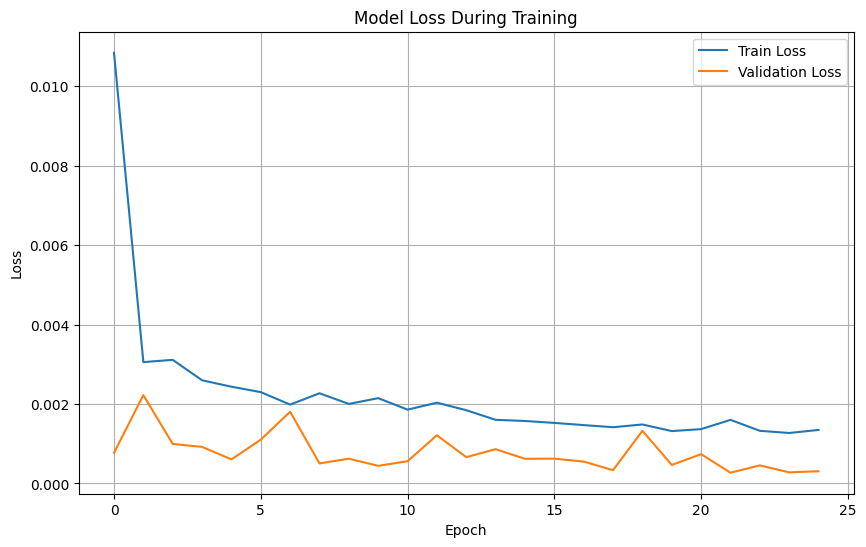

In [10]:
# Create the Sequential model
model = Sequential()

# Add the first LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

# Add a second LSTM layer and Dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Add a third LSTM layer and Dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
print("\n--- Starting Model Training ---")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32, verbose=1)
print("--- Model Training Complete ---")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### LSTM Model Training Diagnostics

The plot above shows the model's loss (Mean Squared Error) over 25 training epochs on both the training data (`Train Loss`) and the unseen validation data (`Validation Loss`).

**Key Observations:**

*   **Learning Progression:** The `Train Loss` (blue line) decreases steadily and consistently, which indicates that the model is effectively learning the patterns within the training dataset.
*   **Generalization Performance:** The `Validation Loss` (orange line) also trends downwards and remains low, closely following the training loss. This is a very positive sign, as it demonstrates that the model is not simply "memorizing" the training data but is able to **generalize** its learnings to new, unseen data.
*   **No Significant Overfitting:** The gap between the training and validation loss is small and does not widen over time. This suggests that our use of Dropout layers was effective in preventing significant overfitting.


## Prediction and Evaluation

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Train RMSE: 1611.88 USD
Test RMSE: 1171.23 USD


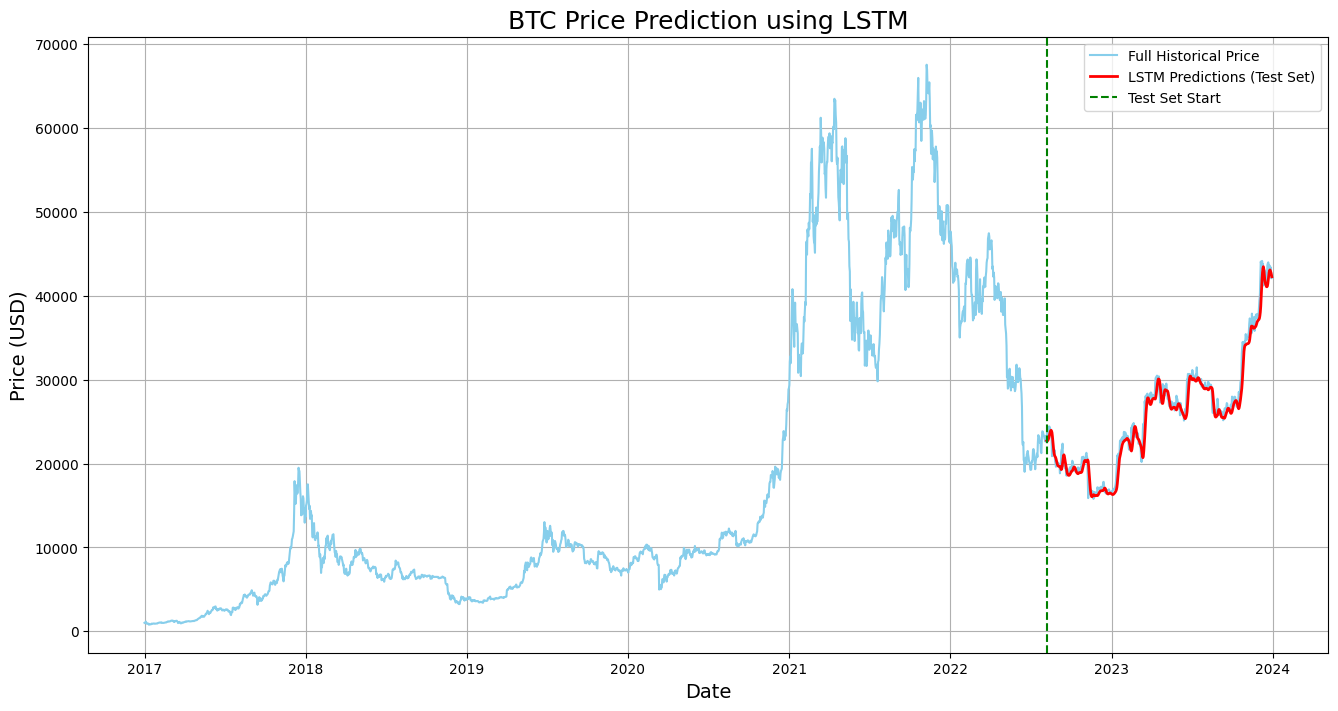


Sample of Predictions vs Actuals:
            Actual Price  Predicted Price
Date                                     
2022-08-07  23175.890625     22720.228516
2022-08-08  23809.486328     22670.671875
2022-08-09  23164.318359     22719.582031
2022-08-10  23947.642578     22790.427734
2022-08-11  23957.529297     22921.837891


In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual price values
train_predict_actual_scale = scaler.inverse_transform(train_predict)
test_predict_actual_scale = scaler.inverse_transform(test_predict)
y_test_actual_scale = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train_actual_scale = scaler.inverse_transform(y_train.reshape(-1, 1))

# Calculate Root Mean Squared Error (RMSE)
train_rmse = math.sqrt(mean_squared_error(y_train_actual_scale, train_predict_actual_scale))
test_rmse = math.sqrt(mean_squared_error(y_test_actual_scale, test_predict_actual_scale))
print(f"Train RMSE: {train_rmse:.2f} USD")
print(f"Test RMSE: {test_rmse:.2f} USD")

# Get the dates for our test set predictions by taking the tail of the original dataframe index
num_predictions = len(test_predict_actual_scale)
test_dates = btc_data.index[-num_predictions:]


# Create a new DataFrame for plotting
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': y_test_actual_scale.flatten(),
    'Predicted Price': test_predict_actual_scale.flatten()
}).set_index('Date')


# Create the final plot
plt.figure(figsize=(16, 8))
# Plot the full historical data
plt.plot(btc_data.index, btc_data['Close'], label='Full Historical Price', color='skyblue')
# Plot the LSTM predictions for the test set on top
plt.plot(results_df.index, results_df['Predicted Price'], label='LSTM Predictions (Test Set)', color='red', linewidth=2)
# Add a vertical line to show where the test set begins
plt.axvline(x=results_df.index[0], color='green', linestyle='--', label='Test Set Start')

plt.title('BTC Price Prediction using LSTM', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Display the first few rows of the results dataframe
print("\nSample of Predictions vs Actuals:")
print(results_df.head())



### LSTM Prediction Results & Evaluation

This final plot showcases the performance of our trained LSTM model on the unseen test data.

**Key Observations from the Plot:**

*   **Excellent Trend Following:** The most striking feature is the model's ability to capture the overall **trend** of the market. The predicted prices (red line) correctly follow the actual price's major movements, including the market bottom in late 2022 and the subsequent recovery rally in 2023.
*   **Natural Lag:** As is typical with time-series forecasting models, the prediction exhibits a slight lag behind the actual price. The model learns from past data, so it reacts to sharp turns in the market rather than anticipating them perfectly.
*   **Quantitative Performance (RMSE):** The model achieved a **Test RMSE of approximately $1171.23**. While this is a significant absolute number, it's a relatively small error in the context of Bitcoin's price, which fluctuated between roughly $16,000 and $45,000 during the test period. The small table of sample predictions confirms that the model consistently predicts values in the correct "ballpark."

**The LSTM model**  proved to be a powerful tool for forecasting the general trend and direction of the price. While not precise enough for high-frequency trading, it provides a highly accurate directional forecast that could be invaluable for longer-term strategic decisions.
